<h1 align='center'> Monte-Carlo (MCMC) - TP6 (Homework due April 28 23h59) </h1>
<h1 align='center'> Samy AIMEUR </h1>
<h4 align='right'><i> author: Hicham Janati </i></h4>


In [30]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

## I - Metropolis-Hastings vs Rejection sampling
We would like to sample from the density function:
$$ f(x) \propto  x^4\exp(- x^2) $$ 
Using the proposal: $g(x) \propto \exp(- \frac{1}{2} x^2) $.

1. Find an empirical bound M so as to apply rejection sampling using g to sample from f and visualize the domination of f by Mg.

In [31]:
x = np.linspace(-10, 10, 1000)
f = lambda x: np.exp(- x ** 2) * x ** 4
g = lambda x: np.exp(- 0.5 * x ** 2)

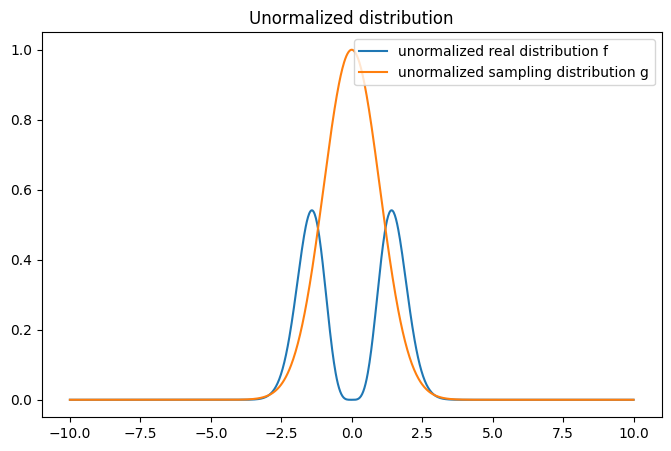

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(x,f(x), label="unormalized real distribution f")
plt.plot(x,g(x), label="unormalized sampling distribution g")
plt.legend()
plt.title("Unormalized distribution")
plt.show()

In [33]:
#First find the normalization constants of f and g
import scipy.integrate as integrate

Cf, _ = integrate.quad(f , x[0], x[-1])
Cg, _ = integrate.quad(g, x[0], x[-1])

norm_f = lambda x : f(x)/Cf
norm_g = lambda x : g(x)/Cg

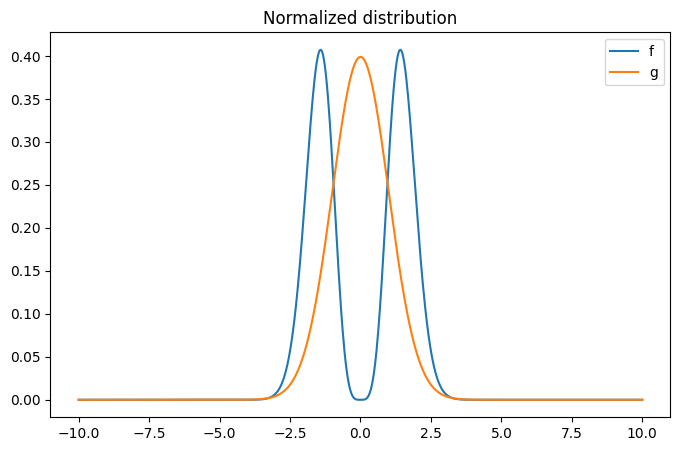

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(x,norm_f(x), label="f")
plt.plot(x,norm_g(x), label="g")
plt.title("Normalized distribution")
plt.legend()
plt.show()

In [35]:
#Find the empirical bound M by taking the supremum of the ratio f/g
M = 0
for i in x :
    if norm_f(i)/norm_g(i) > M:
        M = norm_f(i)/norm_g(i)
print("M =",M)

M = 4.082788337026379


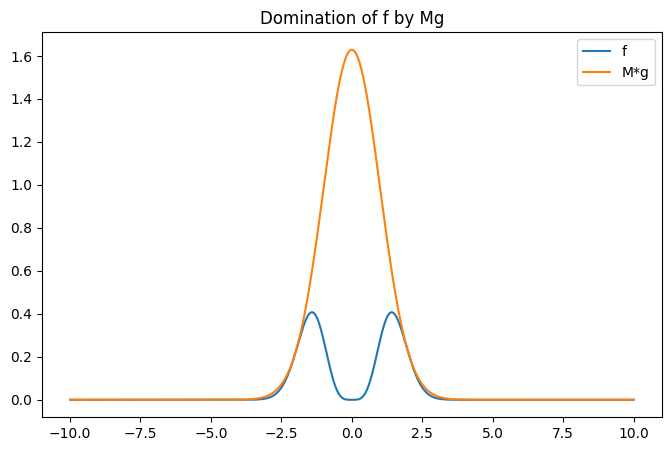

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(x,norm_f(x), label="f")
plt.plot(x,M*norm_g(x), label="M*g")
plt.title("Domination of f by Mg")
plt.legend()
plt.show()

2. Implement the rejection sampling algorithm and visualize the empirical histogram against the density f. Use scipy.integration to estimate the normalizing constant of f for accurate visualization of the density.

In [37]:
def rejection_sampling(n):
    """Reject sampling algorithm for f with Gaussian proposal g."""
    X_list=[]
    while len(X_list)<n :
        u = np.random.rand()
        X = np.random.normal()
        while u > f(X)/(M*g(X)):
            u = np.random.rand()
            X = np.random.normal()
        X_list.append(X)
    return X_list

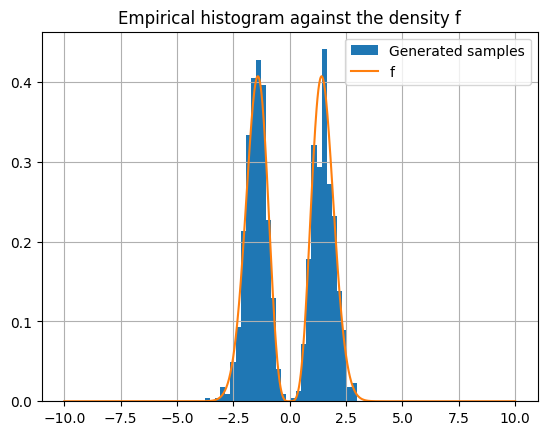

In [38]:
plt.hist(rejection_sampling(1000), bins=30, density=True, label='Generated samples')
plt.plot(x, norm_f(x), label='f')
plt.grid()
plt.legend()
plt.title("Empirical histogram against the density f")
plt.show()

3. Implement the random walk metropolis hastings algorithm with a Gaussian conditional probability and visualize the empirical histogram against the normalized density f/F

In [39]:
def rw_metropolis_hastings(n, f=f, seed=None, sigma = 1):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g.
    n: int.
        number of samples.
    f: callable.
        density we want to sample from.
    seed: int (optional).
        random seed initialization.
    """
    X=[] #our sampling data
    acceptance = 0 #acceptance rate
    if seed != None:
        np.random.seed(seed)
    X.append(np.random.normal(0, sigma)) #We initialize by taking a random point 
    for i in range(1,n):
        xn = X[-1]
        y = xn+sigma*np.random.normal() #We use a gaussian kernel
        u = np.random.rand()
        if u <= f(y)/f(xn): #The gaussian kernel is symetric so it's not present in the ratio
            X.append(y)
            acceptance +=1
        else:
            X.append(xn)
    return X, acceptance/n

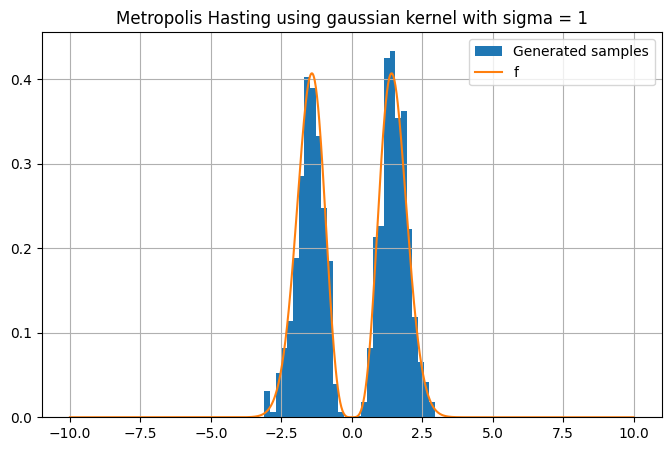

The acceptance ratio with sigma = 1 is : 0.5093333333333333


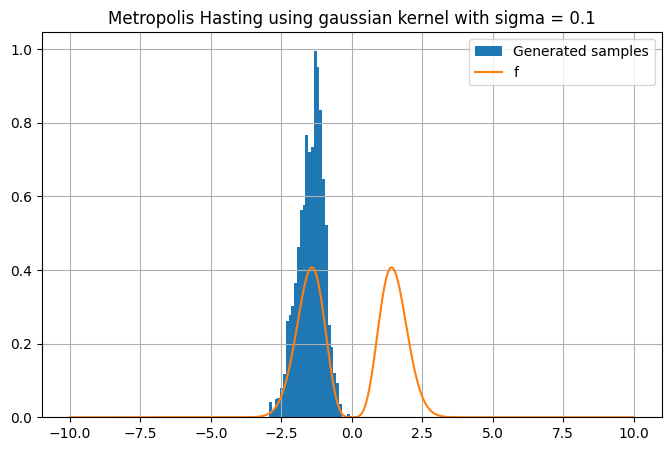

The acceptance ratio with sigma = 0.1 is : 0.9293333333333333


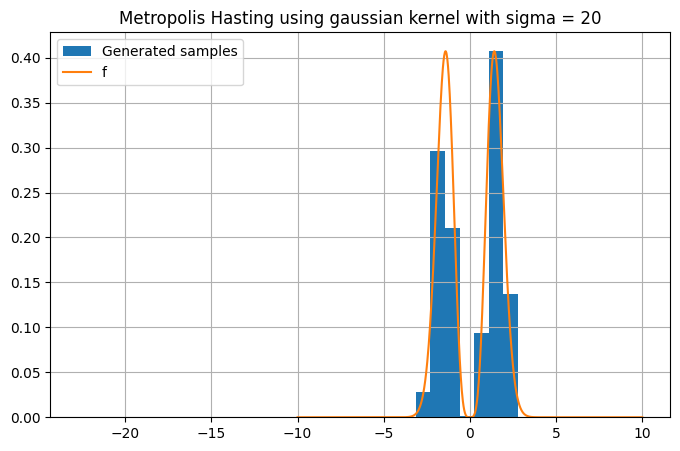

The acceptance ratio with sigma = 20 is : 0.06666666666666667


In [41]:
sigma=1
samples, acceptance_ratio = rw_metropolis_hastings(3000, sigma = sigma)
plt.figure(figsize=(8,5))
plt.hist(samples, bins=30, density=True, label='Generated samples')
plt.plot(x, norm_f(x), label='f')
plt.grid()
plt.legend()
plt.title("Metropolis Hasting using gaussian kernel with sigma = " + str(sigma))
plt.show()
print("The acceptance ratio with sigma =", sigma, "is :", acceptance_ratio)

sigma=0.1
samples, acceptance_ratio = rw_metropolis_hastings(3000, sigma = sigma)
plt.figure(figsize=(8,5))
plt.hist(samples, bins=30, density=True, label='Generated samples')
plt.plot(x, norm_f(x), label='f')
plt.grid()
plt.legend()
plt.title("Metropolis Hasting using gaussian kernel with sigma = " + str(sigma))
plt.show()
print("The acceptance ratio with sigma =", sigma, "is :", acceptance_ratio)

sigma=20
samples, acceptance_ratio = rw_metropolis_hastings(3000, sigma = sigma)
plt.figure(figsize=(8,5))
plt.hist(samples, bins=30, density=True, label='Generated samples')
plt.plot(x, norm_f(x), label='f')
plt.grid()
plt.legend()
plt.title("Metropolis Hasting using gaussian kernel with sigma = " + str(sigma))
plt.show()
print("The acceptance ratio with sigma =", sigma, "is :", acceptance_ratio)

As explain in the lectures note $\sigma$ is a parameter that will drastically impact the algorithm's efficiency.
* With $\sigma << 1$, the generated data $y \approx x$, so the acceptance ratio is $e^{-\frac{1}{2}(y^2 - x^2)}\approx 1$. Therefore, the Markov Chain is mooving but every transition is really small. Because there is no overlaping between our two gaussians lobs, the fact that $\sigma << 1$ also explain why our Markov Chain can't jump from on gaussian lob to the other.

* With $\sigma >> 1$, the generated data $y$ has a high probability to be far from $x$, so the acceptance ratio is $\approx 0$. Therefore, the chain is static and moove very rarely.

One empirical law is to try to gave the acceptance ratio $\approx 0.5$ to have a trade-off those two cases.

In our example we have to take $\sigma \approx 1$.

# II - Gibbs sampling
Gibbs sampling is a Markov Chain sampling algorithm used to sample from a multivariate random variable by sampling each component from its conditional distribution while the others components are fixed.

We would like to sample from a multivariate Gaussian $(X_1, X_2)$ with density:
$$p(x_1, x_2) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)\right) $$
*1. Identify the parameters of the distribution and compute the conditional distributions of each component.*

The general density of a k-dimension multivariate normal distribution with an inversible covariance matrix $\boldsymbol\Sigma$ and a mean $\boldsymbol\mu$ is :

$$ p_{\mathbf X}(x_1,\ldots,x_k) = \frac{\exp\left(-\frac 1 2 \left({\mathbf x} - {\boldsymbol\mu}\right)^\mathrm{T}{\boldsymbol\Sigma}^{-1}\left({\mathbf x}-{\boldsymbol\mu}\right)\right)}{\sqrt{(2\pi)^k |\boldsymbol\Sigma|}}$$

By identification we have :

$$\boldsymbol\Sigma = 

\begin{bmatrix}
1 & \rho \\
\rho & 1
\end{bmatrix} 

\quad, \quad \boldsymbol\mu = 

\begin{bmatrix}
0 \\
0
\end{bmatrix} 


Thus we have : 
$$ p_{X_1}(x_1) =\frac{1}{\sqrt{2\pi} } e^{-\frac{x_1^2}{2}}, \quad p_{X_2}(x_2) =\frac{1}{\sqrt{2\pi}}e^{-\frac{x_2^2}{2}}$$

$$p(x_1|x_2)= \frac{p(x_1,x_2)}{p(x_2)} = \frac{1}{\sqrt{2\pi(1 - \rho^2)}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + \rho^2 x_2^2 - 2\rho x_1 x_2)\right) \\
= \frac{1}{\sqrt{2\pi(1 - \rho^2)}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1 - x_2\rho)^2\right) 
$$

$\implies X_1|X_2 \sim \mathcal{N}(x_2\rho , 1-\rho^2)$

De même on a : $ X_2|X_1 \sim \mathcal{N}(x_1\rho , 1-\rho^2)$

*2. Implement the associated Gibbs sampler where each $X_1, X_2$ are sampled sequentially from the conditional distributions.*

In [42]:
def gibbs_sampler(n, rho, x0 = np.zeros(2)):
    """Gibbs sampler for (X_1, X_2)."""
    X=[x0]
    for i in range (n):
        x_1 = X[-1][1]*rho + (1- rho**2)*np.random.normal()
        x_2 = x_1*rho + (1-rho**2)*np.random.normal()
        X.append([x_1,x_2])
    return np.array(X[1:])

3. Visualize the contour plots of the target distribution and that of the Gibbs Sampler for different values of n. How does it behave with $\rho$ ?

First the target density:

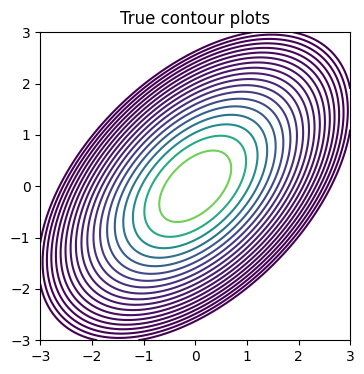

In [43]:
from scipy.stats import multivariate_normal
rho = 0.5
S = np.array([[1, rho], [rho, 1]])
grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)
pos = np.empty((1000, 1000, 2))
pos[:, :, 0] = x
pos[:, :, 1] = y
Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
plt.figure(figsize=(4, 4))
plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
plt.title("True contour plots")
plt.show()

Now we plot the contour plots as the Markov chain moves. Keep in mind that the Markov chain samples are correlated and therefore not iid ! We need to wait a whiler until the MC reaches the stationary distribution. We show this in the following plots:
First we plot everything till a certain iteration:

In [44]:
def plot_gibbs(rho, n, burn_in = 2000):
    S = np.array([[1, rho], [rho, 1]])
    grid = np.linspace(-3, 3, 1000)
    x, y = np.meshgrid(grid, grid)
    pos = np.empty((1000, 1000, 2))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
    plt.figure(figsize=(8, 6))
    plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
    plt.title("True contour plots")
    samples = gibbs_sampler(n+burn_in, rho)
    plt.plot(samples[burn_in:,0], samples[burn_in:,1], 'r.', markersize=2,  label = 'samples')
    plt.legend(loc = 2)
    plt.title('Gibbs sampling with n = '+str(n)+ ' and rho = '+str(rho))
    plt.show()

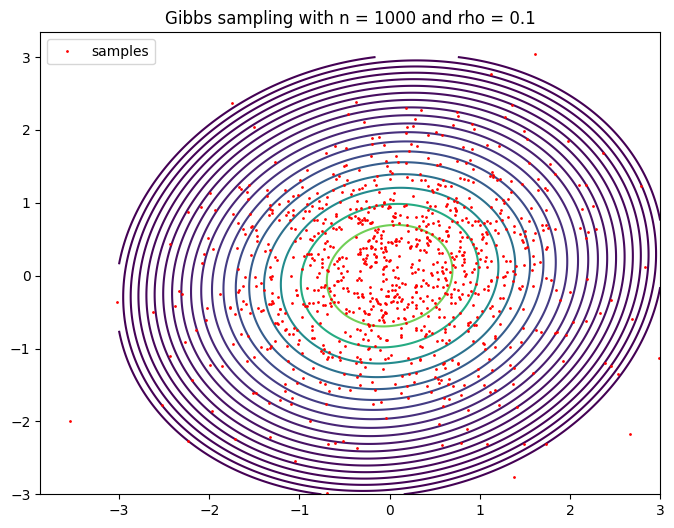

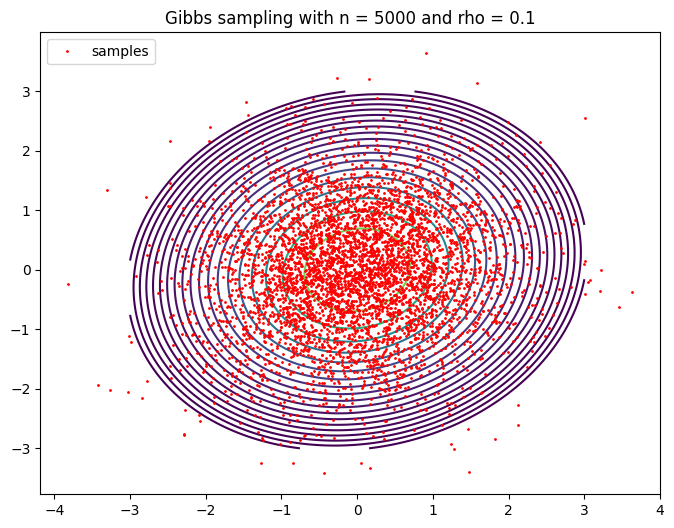

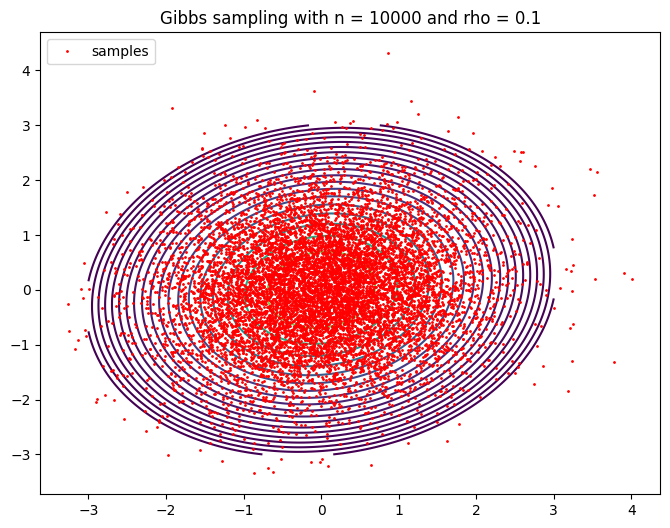

In [45]:
#rho = 0.1
rho = 0.1
plot_gibbs(rho, 1000)
plot_gibbs(rho, 5000)
plot_gibbs(rho, 10000)

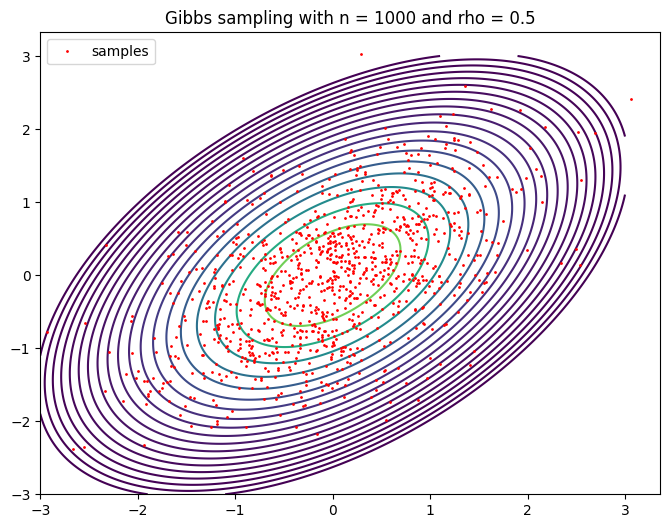

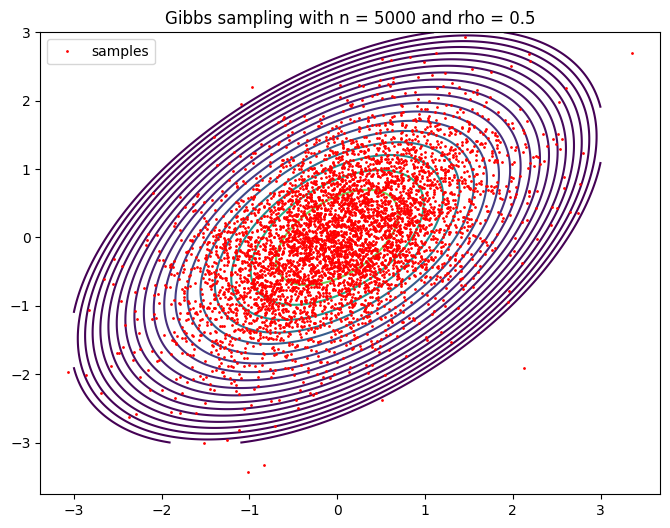

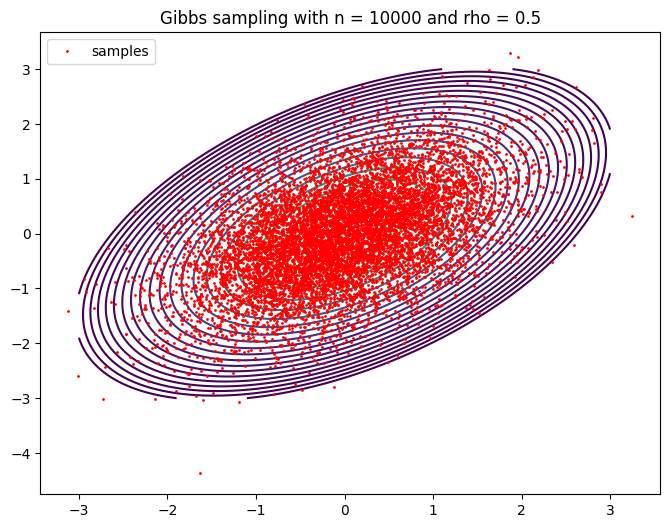

In [46]:
#rho = 0.5
rho = 0.5
plot_gibbs(rho, 1000)
plot_gibbs(rho, 5000)
plot_gibbs(rho, 10000)

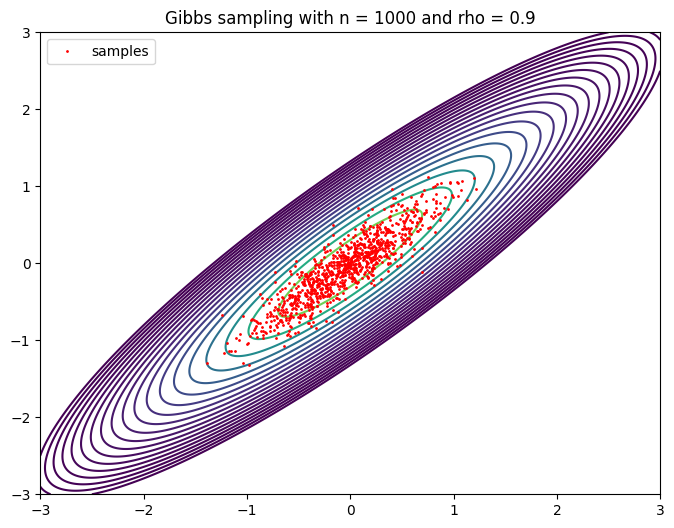

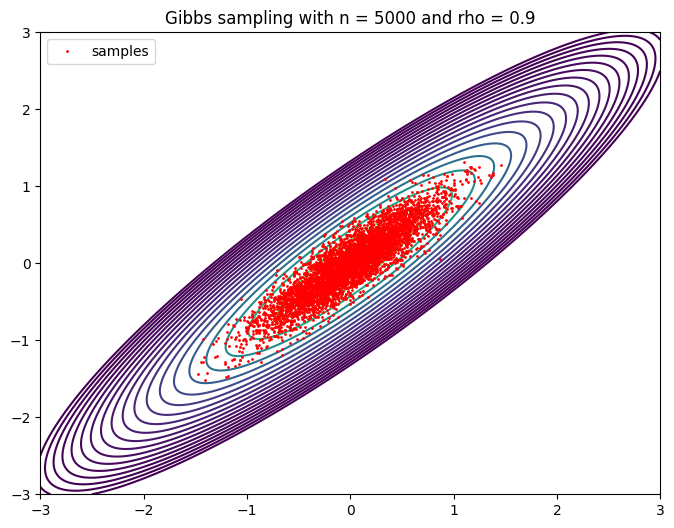

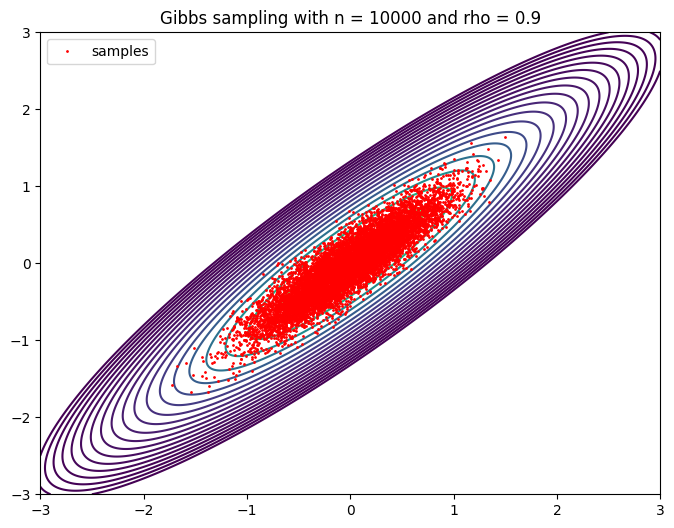

In [47]:
#rho = 0.9
rho = 0.9
plot_gibbs(rho, 1000)
plot_gibbs(rho, 5000)
plot_gibbs(rho, 10000)

The greater $\rho$ is, the more correlated $X_1$ and $X_2$ are. 

This graphically translates into a privileged direction of the distribution according to the vector $\begin{pmatrix} 1 \\ 1 \end{pmatrix}$.

4. Using the numpy corrcoef function, plot the auto-correlation values as a function of the lag: $corr(X_t, X_{t - lag})$

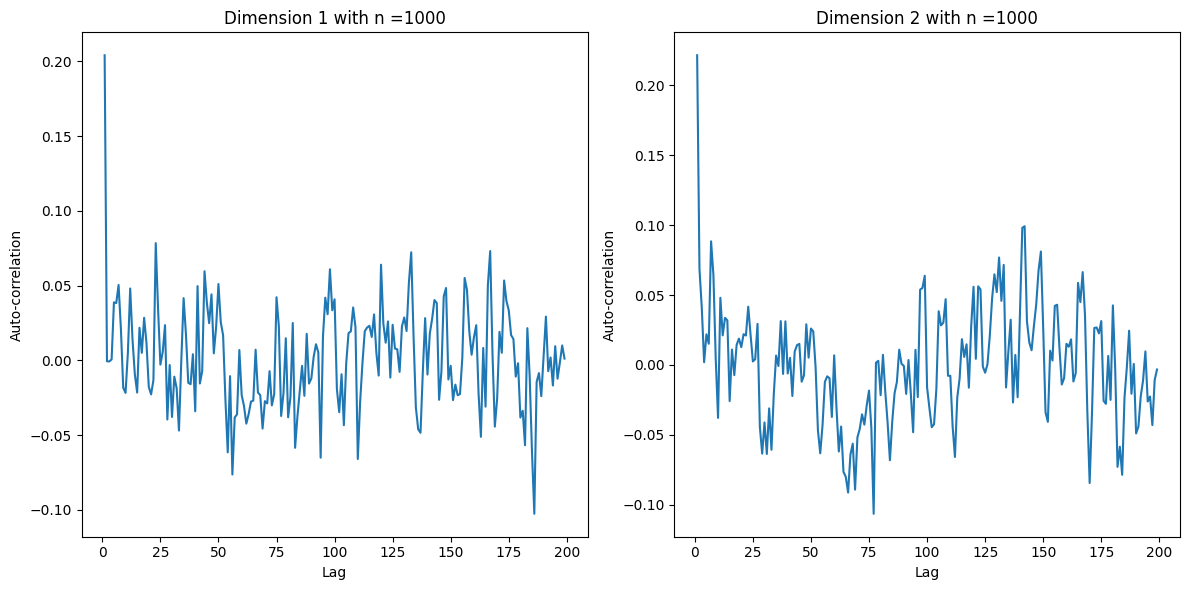

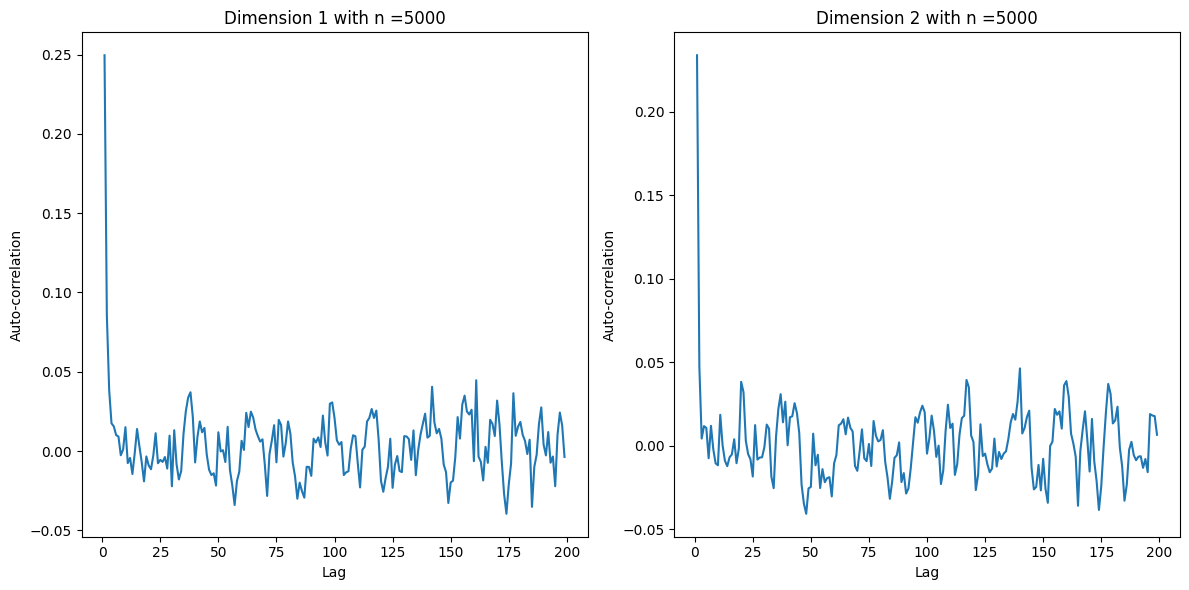

In [48]:
#n=1000
n=1000
samples = gibbs_sampler(n, 0.5)

lags = range(1, 200)
auto_corr_1 = [np.corrcoef(samples[:-lag, 0], samples[lag:, 0])[0, 1] for lag in lags]
auto_corr_2 = [np.corrcoef(samples[:-lag, 1], samples[lag:, 1])[0, 1] for lag in lags]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lags, auto_corr_1)
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.title('Dimension 1 with n ='+str(n))

plt.subplot(1, 2, 2)
plt.plot(lags, auto_corr_2)
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.title('Dimension 2 with n ='+str(n))

plt.tight_layout()
plt.show()


#n=5000
n=5000
samples = gibbs_sampler(n, 0.5)
lags = range(1, 200)
auto_corr_1 = [np.corrcoef(samples[:-lag, 0], samples[lag:, 0])[0, 1] for lag in lags]
auto_corr_2 = [np.corrcoef(samples[:-lag, 1], samples[lag:, 1])[0, 1] for lag in lags]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lags, auto_corr_1)
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.title('Dimension 1 with n ='+str(n))

plt.subplot(1, 2, 2)
plt.plot(lags, auto_corr_2)
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.title('Dimension 2 with n ='+str(n))

plt.tight_layout()
plt.show()

5. Using what you observe, propose two arguments to add to your Gibbs sampler function to improve the simulation.
What happens when $\rho \to 1$ ?

We can see that the more data we have the less they are correlated.

We can add two new arguments :

* Burn-in Period: One common technique to improve the Gibbs sampler is to discard a certain number of the initial samples, a process known as the "burn-in". This is because the initial samples are often far from the target distribution, especially if the initial point is not well chosen. An argument could be added to the function to specify the length of the burn-in period.

* Thinning: Another technique to improve the Gibbs sampler is "thinning". This involves only keeping every nth sample. This can help to reduce the autocorrelation of the samples and make the samples more like independent draws from the target distribution. An argument could be added to the function to specify the thinning interval.

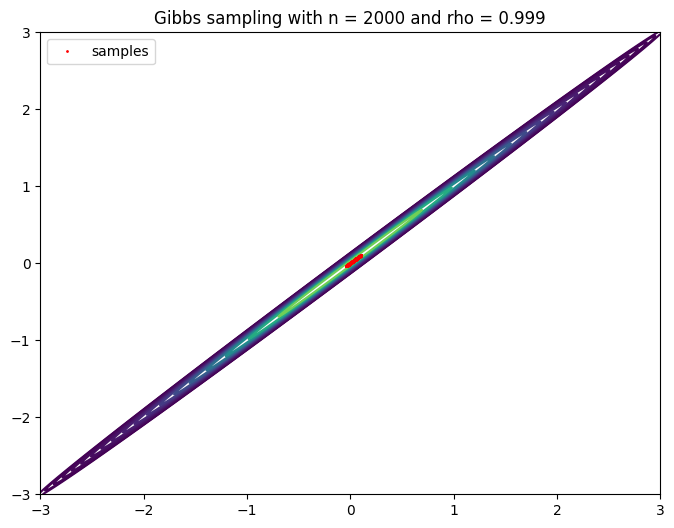

In [49]:
#rho almost equal to 1
plot_gibbs(0.999, 2000)

When $\rho$ is close to 1, the variables become highly correlated. In the context of the Gibbs sampler, this can cause problems because the sampler can get stuck in a narrow, high-probability region of the distribution and take a long time to explore the rest of the distribution. This is known as poor mixing. As a result, the Markov chain may fail to converge, or may take a very long time to converge. This is why the Gibbs sampler can perform poorly when the variables are highly correlated.

6. Implement a Random Walk metropolis algorithm to simulate from p using a conditional proposal $\mathcal N(0, \tau I_2)$ and vary $\tau$. 

In [50]:
def rw_metropolis_hastings(n, f, tau=1., seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g."""
    X=[] #our sampling data
    acceptance = 0 #acceptance rate
    if seed != None:
        np.random.seed(seed)
    X.append(np.random.normal(0, tau, size= 2)) #We initialize by taking a random point 
    for i in range(n):
        xn = X[-1]
        y = xn+np.random.normal(0, tau, size =2) #We use a gaussian kernel
        u = np.random.rand()
        if u <= f(y[0],y[1])/f(xn[0],xn[1]): #The gaussian kernel is symetric so it's not present in the ratio
            X.append(y)
            acceptance +=1
        else:
            X.append(xn)
    return np.array(X[1:]), acceptance/n

$$\frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)\right)

In [51]:
def p(x1, x2 ,rho = 0.5):
    return 1/(2*np.pi*np.sqrt(1-rho**2))*np.exp(-1/(2*(1-rho**2))*(x1**2 + x2**2 -2*rho*x1*x2))

In [52]:
def plot_rw_multi(n, tau, rho = 0.5, burn_in = 0):
    S = np.array([[1, rho], [rho, 1]])
    grid = np.linspace(-3, 3, 1000)
    x, y = np.meshgrid(grid, grid)
    pos = np.empty((1000, 1000, 2))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
    plt.figure(figsize=(8, 6))
    plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
    plt.title("True contour plots")
    samples = rw_metropolis_hastings(n+burn_in,p, tau = tau)[0]
    plt.plot(samples[burn_in:,0], samples[burn_in:,1], 'r.', markersize=2,  label = 'samples')
    #plt.scatter(samples[burn_in:,0], samples[burn_in:,1], label='Sample',alpha=.5, s= 3) #Another style of plot
    plt.legend(loc = 2)
    plt.title('Gibbs sampling with n = '+str(n)+ ' and rho = '+str(rho) + ' and tau = '+str(tau))
    plt.show()

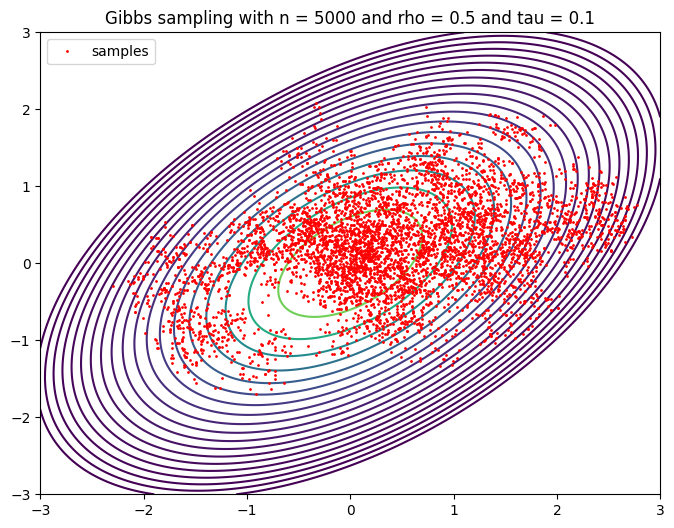

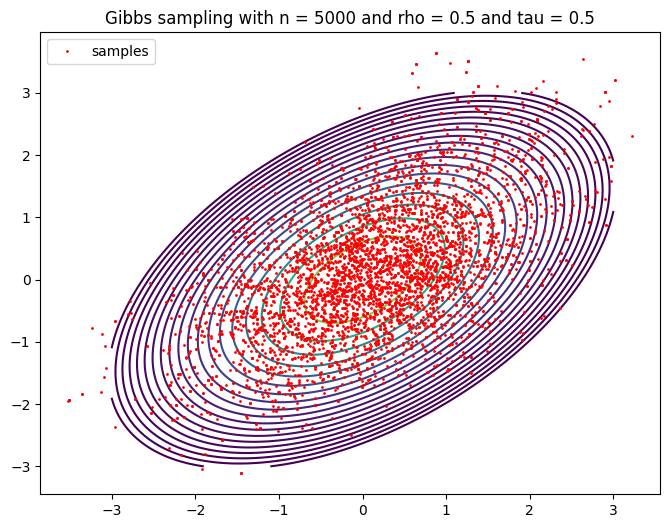

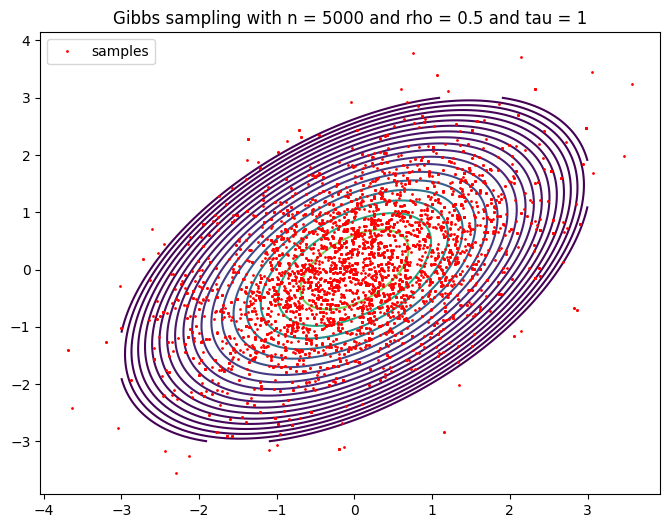

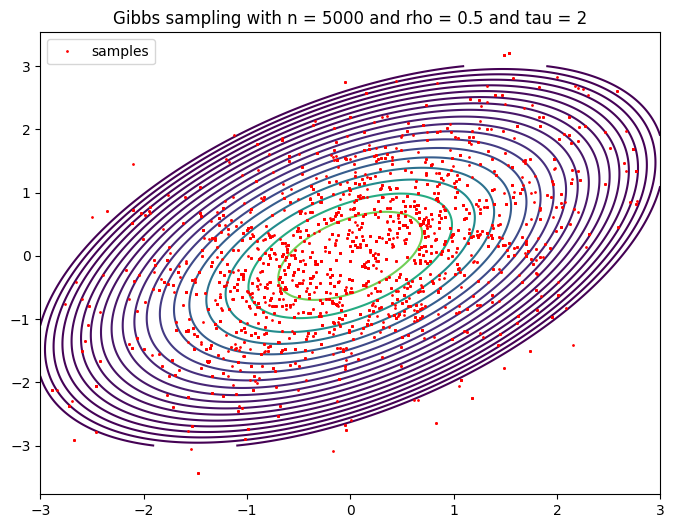

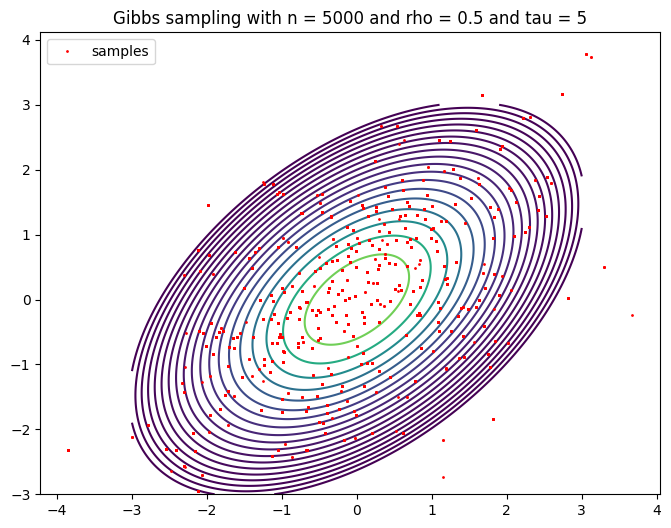

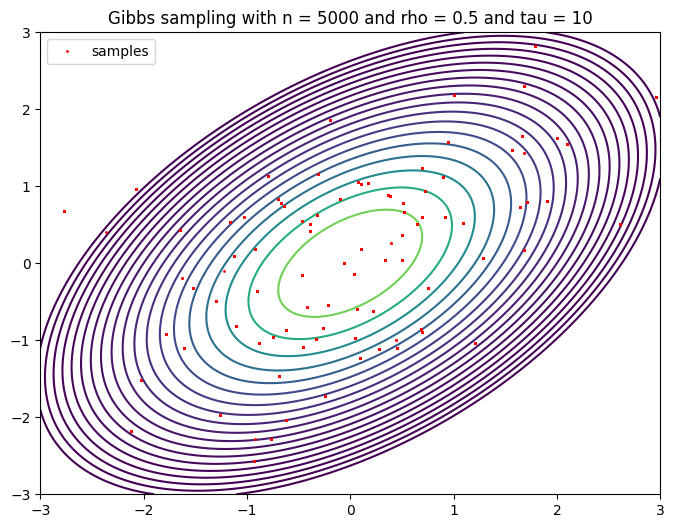

In [53]:
plot_rw_multi(5000, 0.1, burn_in= 1000)
plot_rw_multi(5000, 0.5, burn_in= 1000)
plot_rw_multi(5000, 1, burn_in= 1000)
plot_rw_multi(5000, 2, burn_in= 1000)
plot_rw_multi(5000, 5, burn_in= 1000)
plot_rw_multi(5000, 10, burn_in= 1000)

For $\tau >>1$ and  $\tau << 1$, we have the same graphical explanation as explain in question 3 of part $I$.

Here for $\tau >>1$, we still have 5000 samples but with a lot of duplicates and about thirty unique values of samples.